FFNN Model Structure:
Input Layer: 2 neurons, Activation: linear
Layer 1: 2 neurons, Activation: sigmoid
Weights:
[[-0.25091976  0.90142861]
 [ 0.46398788  0.19731697]]
Biases:
[[-0.68796272]
 [-0.68801096]]
Weight Gradients:
[[0. 0.]
 [0. 0.]]
Bias Gradients:
[[0.]
 [0.]]
----------------------------------------
Layer 2: 1 neurons, Activation: sigmoid
Weights:
[[-0.88383278  0.73235229]]
Biases:
[[0.20223002]]
Weight Gradients:
[[0. 0.]]
Bias Gradients:
[[0.]]
----------------------------------------


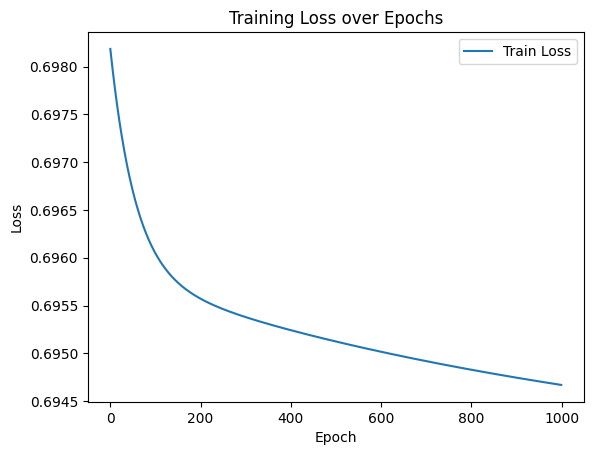

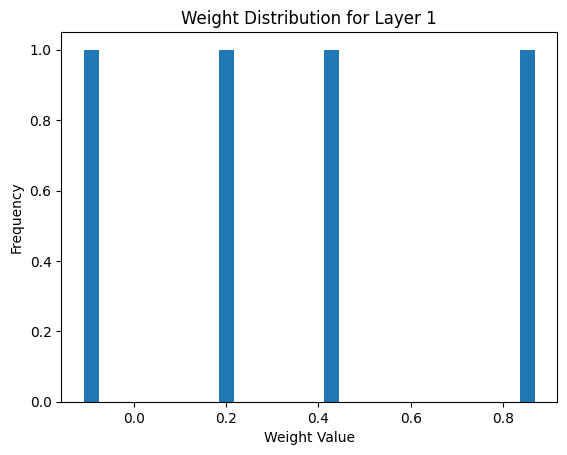

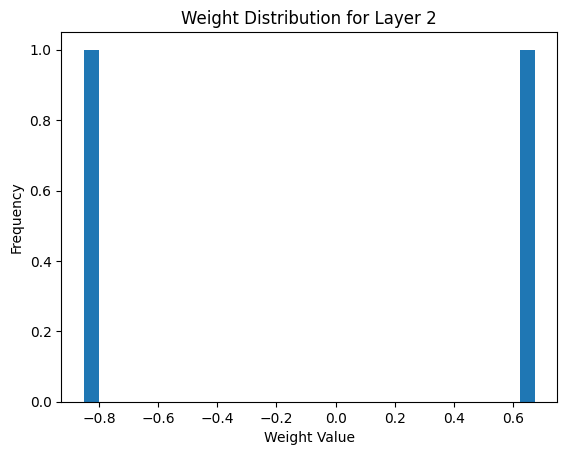

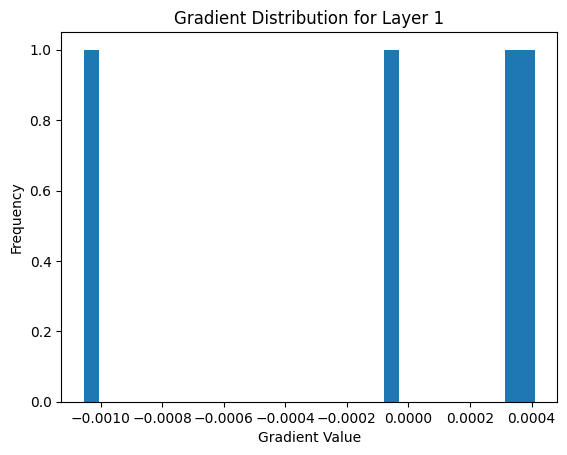

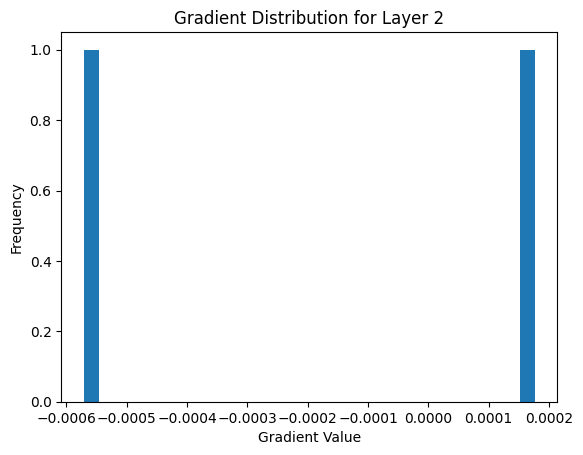

Model saved to ffnn_model.pkl
Model loaded from ffnn_model.pkl


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm  # For progress bar display during trainingd

def linear(x):
    return x

def d_linear(x):
    return np.ones_like(x)

def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1 - np.tanh(x) ** 2

def softmax(x):
    ex = np.exp(x - np.max(x, axis=0, keepdims=True))
    return ex / np.sum(ex, axis=0, keepdims=True)

def d_softmax(x):
    # Not used directly when softmax is paired with cross entropy loss.
    return np.ones_like(x)


# ------------------------------
# FFNN Class Definition
# ------------------------------

class FFNN:
    def __init__(self, layer_sizes, activations, weight_init='random_uniform', init_params={}):
        """
        Parameters:
          layer_sizes: List of integers specifying the number of neurons in each layer 
                       (including input and output layers).
          activations: List of activation function names for each layer.
                       (For the input layer, a "linear" activation is suggested.)
          weight_init: String specifying initialization method: 'zero', 'random_uniform', or 'random_normal'.
          init_params: Dictionary with parameters for initialization.
                       For 'random_uniform': keys 'lower', 'upper', 'seed'
                       For 'random_normal': keys 'mean', 'variance', 'seed'
        """
        if len(layer_sizes) != len(activations):
            raise ValueError("layer_sizes and activations must have the same length.")
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.L = len(layer_sizes)  # Total number of layers (including input layer)
        self.weights = {}          # Dictionary to store weights for layers 1 to L-1
        self.biases = {}           # Dictionary to store biases for layers 1 to L-1
        self.weight_grads = {}     # Dictionary to store gradients of weights
        self.bias_grads = {}       # Dictionary to store gradients of biases
        self.cache = {}            # Cache to store intermediate values for backpropagation
        
        # Get activation functions and loss functions mappings
        self.activation_functions = self.get_activation_functions()
        self.loss_functions = self.get_loss_functions()
        
        # Initialize weights and biases for layers 1 to L-1
        self.initialize_weights(weight_init, init_params)

    def get_activation_functions(self):
        """
        Returns a dictionary mapping activation names (in lowercase) to a tuple of
        (activation_function, derivative_function).
        """
        funcs = {}
        funcs['linear'] = (linear, d_linear)
        funcs['relu'] = (relu, d_relu)
        funcs['sigmoid'] = (sigmoid, d_sigmoid)
        funcs['tanh'] = (tanh, d_tanh)
        funcs['softmax'] = (softmax, d_softmax)
        return funcs

    def get_loss_functions(self):
        """
        Returns a dictionary mapping loss function names to a tuple of 
        (loss_function, derivative_function).
        """
        funcs = {}
        funcs['mse'] = (self.mse_loss, self.mse_loss_derivative)
        funcs['binary_cross_entropy'] = (self.binary_cross_entropy_loss, self.binary_cross_entropy_derivative)
        funcs['categorical_cross_entropy'] = (self.categorical_cross_entropy_loss, self.categorical_cross_entropy_derivative)
        return funcs

    def initialize_weights(self, method, params):
        """
        Initialize weights and biases for layers 1 to L-1.
        """
        if 'seed' in params:
            np.random.seed(params['seed'])
        for l in range(1, self.L):
            n_out = self.layer_sizes[l]
            n_in = self.layer_sizes[l - 1]
            if method == 'zero':
                self.weights[l] = np.zeros((n_out, n_in))
                self.biases[l] = np.zeros((n_out, 1))
            elif method == 'random_uniform':
                lower = params.get('lower', -0.5)
                upper = params.get('upper', 0.5)
                self.weights[l] = np.random.uniform(lower, upper, (n_out, n_in))
                self.biases[l] = np.random.uniform(lower, upper, (n_out, 1))
            elif method == 'random_normal':
                mean = params.get('mean', 0)
                var = params.get('variance', 1)
                self.weights[l] = np.random.normal(mean, np.sqrt(var), (n_out, n_in))
                self.biases[l] = np.random.normal(mean, np.sqrt(var), (n_out, 1))
            else:
                raise ValueError("Unknown initialization method.")
            # Initialize gradients as zeros with same shape
            self.weight_grads[l] = np.zeros_like(self.weights[l])
            self.bias_grads[l] = np.zeros_like(self.biases[l])

    # Loss function implementations
    def mse_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

    def mse_loss_derivative(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.size

    def binary_cross_entropy_loss(self, y_pred, y_true):
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def binary_cross_entropy_derivative(self, y_pred, y_true):
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -(y_true / y_pred - (1 - y_true) / (1 - y_pred)) / y_true.size

    def categorical_cross_entropy_loss(self, y_pred, y_true):
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        # Assuming y_true is one-hot encoded and shape (num_classes, batch_size)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=0))

    def categorical_cross_entropy_derivative(self, y_pred, y_true):
        # When softmax is used in the output layer, the derivative simplifies to (y_pred - y_true) / m.
        return (y_pred - y_true) / y_true.shape[1]

    def forward(self, X):
        """
        Perform forward propagation.
        X: Input data with shape (input_size, batch_size)
        Returns the final output.
        """
        # For the input layer, apply the specified activation (often linear, i.e. pass-through)
        act_func_input = self.activation_functions[self.activations[0].lower()][0]
        A = act_func_input(X)
        self.cache[0] = A  # Cache the input activation
        # Forward propagate through each subsequent layer
        for l in range(1, self.L):
            Z = np.dot(self.weights[l], A) + self.biases[l]
            # Store the linear combination and the activation output for backprop
            activation_func = self.activation_functions[self.activations[l].lower()][0]
            A = activation_func(Z)
            self.cache[l] = (Z, A)
        return A

    def backward(self, X, y, loss_name):
        """
        Perform backward propagation to compute gradients.
        X: Input data with shape (input_size, batch_size)
        y: True labels with shape matching the output layer
        loss_name: A string indicating the loss function to use ('mse', 'binary_cross_entropy', etc.)
        """
        m = y.shape[1]
        # Get loss derivative function
        loss_func, loss_deriv = self.loss_functions[loss_name]
        # Forward pass (ensuring cache is populated)
        A_final = self.forward(X)
        # Compute gradient of loss with respect to output activation
        dA = loss_deriv(A_final, y)
        # Propagate gradients backward from the last layer to the first hidden layer
        for l in reversed(range(1, self.L)):
            Z, A = self.cache[l]
            activation_deriv = self.activation_functions[self.activations[l].lower()][1]
            dZ = dA * activation_deriv(Z)
            # Get previous layer activation
            A_prev = self.cache[0] if l - 1 == 0 else self.cache[l - 1][1]
            self.weight_grads[l] = np.dot(dZ, A_prev.T) / m
            self.bias_grads[l] = np.sum(dZ, axis=1, keepdims=True) / m
            dA = np.dot(self.weights[l].T, dZ)
        # (No backpropagation for input layer weights since there are none)

    def update_weights(self, learning_rate):
        """
        Update weights and biases using gradient descent.
        """
        for l in range(1, self.L):
            self.weights[l] -= learning_rate * self.weight_grads[l]
            self.biases[l] -= learning_rate * self.bias_grads[l]

    def train(self, X_train, y_train, X_val=None, y_val=None,
              epochs=100, batch_size=32, learning_rate=0.01, loss_name='mse', verbose=1):
        """
        Train the FFNN using gradient descent.
        Parameters:
          X_train: Training inputs of shape (input_size, num_examples)
          y_train: Training labels of shape (output_size, num_examples)
          X_val, y_val: (Optional) validation data.
          epochs: Number of epochs to train.
          batch_size: Size of mini-batches.
          learning_rate: Learning rate for gradient descent.
          loss_name: Which loss function to use ('mse', 'binary_cross_entropy', or 'categorical_cross_entropy').
          verbose: 0 for no output; 1 for printing progress.
        Returns:
          A history dictionary containing training loss and validation loss per epoch.
        """
        history = {'train_loss': [], 'val_loss': []}
        m = X_train.shape[1]
        for epoch in tqdm(range(epochs), desc="Training", disable=(verbose==0)):
            # Shuffle the training data
            permutation = np.random.permutation(m)
            X_train = X_train[:, permutation]
            y_train = y_train[:, permutation]
            epoch_loss = 0
            for i in range(0, m, batch_size):
                end = i + batch_size if i + batch_size <= m else m
                X_batch = X_train[:, i:end]
                y_batch = y_train[:, i:end]
                # Forward pass
                y_pred = self.forward(X_batch)
                # Compute loss
                loss_value = self.loss_functions[loss_name][0](y_pred, y_batch)
                epoch_loss += loss_value * (end - i)
                # Backward pass and weight update
                self.backward(X_batch, y_batch, loss_name)
                self.update_weights(learning_rate)
            epoch_loss /= m
            history['train_loss'].append(epoch_loss)
            if X_val is not None and y_val is not None:
                y_val_pred = self.forward(X_val)
                val_loss = self.loss_functions[loss_name][0](y_val_pred, y_val)
            else:
                val_loss = None
            history['val_loss'].append(val_loss)
            if verbose:
                if val_loss is not None:
                    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}")
        return history

    def plot_weight_distribution(self, layers):
        """
        Plot the histogram of weights for the specified layer indices.
        Parameters:
          layers: List of layer indices (keys from self.weights) to plot.
        """
        for l in layers:
            if l in self.weights:
                plt.figure()
                plt.hist(self.weights[l].flatten(), bins=30)
                plt.title(f'Weight Distribution for Layer {l}')
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
                plt.show()
            else:
                print(f"Layer {l} does not exist.")

    def plot_gradient_distribution(self, layers):
        """
        Plot the histogram of gradients for the specified layer indices.
        Parameters:
          layers: List of layer indices (keys from self.weight_grads) to plot.
        """
        for l in layers:
            if l in self.weight_grads:
                plt.figure()
                plt.hist(self.weight_grads[l].flatten(), bins=30)
                plt.title(f'Gradient Distribution for Layer {l}')
                plt.xlabel('Gradient Value')
                plt.ylabel('Frequency')
                plt.show()
            else:
                print(f"Layer {l} does not exist.")

    def display_model_graph(self):
        """
        Display a simple text-based representation of the model’s structure
        including neurons per layer and current weights/gradients.
        """
        print("FFNN Model Structure:")
        for l in range(self.L):
            if l == 0:
                print(f"Input Layer: {self.layer_sizes[l]} neurons, Activation: {self.activations[l]}")
            else:
                print(f"Layer {l}: {self.layer_sizes[l]} neurons, Activation: {self.activations[l]}")
                print("Weights:")
                print(self.weights[l])
                print("Biases:")
                print(self.biases[l])
                print("Weight Gradients:")
                print(self.weight_grads[l])
                print("Bias Gradients:")
                print(self.bias_grads[l])
                print("-" * 40)

    def save(self, filename):
        """
        Save the model to a file using pickle.
        """
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {filename}")

    @classmethod
    def load(cls, filename):
        """
        Load a model from a file.
        """
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from {filename}")
        return model


# -------------------------------
# Example usage of the FFNN class
# -------------------------------
if __name__ == "__main__":
    # For demonstration, we use a simple XOR problem for binary classification.
    # XOR dataset: 2 inputs and 1 binary output.
    X = np.array([[0, 0, 1, 1],
                  [0, 1, 0, 1]])  # Shape: (2, 4)
    y = np.array([[0, 1, 1, 0]])  # Shape: (1, 4)
    
    # Define network structure:
    # - Input layer with 2 neurons,
    # - One hidden layer with 2 neurons,
    # - Output layer with 1 neuron.
    layer_sizes = [2, 2, 1]
    # Specify activation functions for each layer.
    # For the input layer, we use 'linear' (pass-through).
    # For hidden and output layers, we use 'sigmoid'.
    activations = ['linear', 'sigmoid', 'sigmoid']
    
    # Initialize the network with random uniform weights.
    init_params = {'lower': -1, 'upper': 1, 'seed': 42}
    model = FFNN(layer_sizes, activations, weight_init='random_uniform', init_params=init_params)
    
    # Display the network structure and initial weights/gradients.
    model.display_model_graph()
    
    # Train the model.
    # Here we use binary cross entropy loss suitable for binary classification.
    history = model.train(X, y, epochs=1000, batch_size=4, learning_rate=0.1,
                          loss_name='binary_cross_entropy', verbose=0)
    
    # Plot training loss history.
    plt.figure()
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # Plot weight and gradient distributions for layers 1 and 2.
    model.plot_weight_distribution([1, 2])
    model.plot_gradient_distribution([1, 2])
    
    # Save and load the model.
    model.save("ffnn_model.pkl")
    loaded_model = FFNN.load("ffnn_model.pkl")